# Object localisation and detection

* Classification is about determining whether something is in a picture. Does this image contain a cat, a dog or a bird?


* Classifiaction and localisation is about determining whether something is in a picture, but, additionally finding where in the image the object is. Here, the goal is to draw a bounding box around the object. Typically, there is only one object in the image.

* Detection, on the other hand, is about finding the location and classification of multiple entities within an image. Typically, there are multiple objects (from different classes) in the image you are trying to find.

Here is a very famous image:

![](https://miro.medium.com/max/1400/1*Hz6t-tokG1niaUfmcysusw.jpeg)

* **Question**: In which real world application might you expect to see each of the first three types of problems shown above in the picture.

* From what we saw before, you would typically follow this type of approach. You would have an input image which you would pass through a convolutional neural network and then you would have a softmax output layer with the same number of units as classes. You might have an additional class called "background" which denotes that there is an absense the objects you are interested in. *See image below.*

* **Question** How would you suggest that we modify the network such that we can locate the objects were are interested in?

<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

What we can do is to add four extra network units that denote the midpoint of the object along with the height and width. *See image below.*

* **Question:** what does this mean in terms of our training data? How will it have to be modified? What do you think the values of $b_x, b_y, b_w, b_h$ should be in this example, roughly?

<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

* **Question:** How exactly can we define the targets y?

<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

1. We can define a variable $p_c$ as the presence of an object, and set it to 1 if there is an object, and set it to 0 otherwise. So if the image is class 4, then $p_c = 0$, and if the image class is say class 3, then $p_c = 1$, similarly for classes 1 and 2.

2. We need to also have values of $b_x, b_y, b_w, b_h$ in y.

3. We need to also have the one-hot encoded vector, as before, so let us call this $c_1, c_2, c_3$.

*See image below.*



* **Question:** Can you guess how we will encode the target, y, for each of the classes. Start with pedestrian, car, motocycle and background.

<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

*See image below.*

In the case of $p_c = 0$, the $?$ marks denote "don't care" as this is not relevant when there is no object that needs to be classified.

* **Question:** Now that we have formally defined our encoding of y, and we would have some images x, what is the final step needed before training the network?

<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

The last step needed is to define the loss function.

Given $y$ which is the true target and $\hat{y}$. $y$ can be expressed as $y_1, y_2, \dots, y_8$, where $y_1 = p_c$ and so on.

So our loss function can be as follows:

* if $y_1 = 0$ then $L(y,\hat{y}) = (\hat{y_1} - y_1)^2$ this makes sense since we don't care about the other values here as there is no object in the image.

* if $y_1 = 1$ then $L(y,\hat{y}) = (\hat{y_1} - y_1)^2 + (\hat{y_2} - y_2)^2 + \dots + (\hat{y_8} - y_8)^2$

Note that ff you wanted to, you could have a cross entropy loss for the class values (softmax values).

The above discussion was about object locationation, not detection.

Next, we talk about detection.

## Landmark detection

What if we wanted to build an algorithm to detect facial key landmarks, such as the location of the eyes, nose and mouth. **How would we modify the targets? What do we need to worry about in terms of the target labelling**


<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

*See image below.*

* What applications (related to facial landmarks) can you think of for which this would be useful?

* What applications (related to any field) can you think of for which this would be useful?

* How could this idea to extended to pose estimation? *See below.*



# Task: Implement a land mark detection algorithm

**Dataset:**

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

In [ ]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
from google.colab import files
from sklearn.utils import shuffle

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

test_file = '1eVzKGRlHPCNqkwaZFz_ZM7Q0UNCiQ0h_'
downloaded = drive.CreateFile({'id': test_file})
downloaded.GetContentFile('test.csv')

train_file = '1uLQ307pPe5bEOLHEzdb2CqOKfKZXTS2y'
downloaded = drive.CreateFile({'id': train_file})
downloaded.GetContentFile('training.zip')

In [ ]:
!unzip "training.zip"

Archive:  training.zip
  inflating: training.csv            


In [ ]:
def loadData(train, dFrame):
  dFrame['Image'] = dFrame['Image'].apply(lambda row: np.fromstring(row, sep=' '))
  print(dFrame.shape)
  dFrame = dFrame.dropna()  # drop all rows that have missing values in them
  print(dFrame.shape)
  X = np.vstack(dFrame['Image'].values) / 255.  # scale pixel values to [0, 1] and
  X = X.astype(np.float32)
  X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1
  print(X.shape)

  if train:
    y = dFrame[dFrame.columns[:-1]].values
    #print(y.shape)
    #print(y[0:2])
    y = (y - 48) / 48  # scale target coordinates to [-1, 1] THIS IS THE IMPORTANT PART HERE! HOW TO GET THE COORDS TO WORK FOR ANY SIZE IMAGE
    #print(y.shape)
    #print(y[0:2])
    X, y = shuffle(X, y, random_state=42)  # shuffle train data
    y = y.astype(np.float32)
  else:
    y = None

  return X, y

In [ ]:
dFrame = pd.read_csv("training.csv")

In [ ]:
dFrame.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [ ]:
#dFrame['Image'].shape
#dFrame.head(2)
type(dFrame['Image'].values)
type(dFrame['Image'].values[1])
dFrame['Image'].values[1]
dFrame['left_eye_center_x'].values == 0.0
#dFrame['left_eye_center_x'].values
#type(dFrame['left_eye_center_x'].values[0])

array([False, False, False, ..., False, False, False])

In [ ]:
X_train, y_train = loadData(True, dFrame)

(7049, 31)
(2140, 31)
(2140, 96, 96, 1)


In [ ]:
dFrame = pd.read_csv("test.csv")

In [ ]:
dFrame.columns

Index(['ImageId', 'Image'], dtype='object')

In [ ]:
X_test, y_test = loadData(False, dFrame)

(1783, 2)
(1783, 2)
(1783, 96, 96, 1)


In [ ]:
X_train.shape

(2140, 96, 96, 1)

In [ ]:
y_train.shape

(2140, 30)

In [ ]:
X_test.shape

(1783, 96, 96, 1)

In [ ]:
def plotData(image, landmarks, figure):
    print(image)
    figure.imshow(np.squeeze(image), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    figure.scatter(landmarks[0::2],landmarks[1::2],marker='o',c='r',s=10)

[[[0.79607844]
  [0.7058824 ]
  [0.59607846]
  ...
  [0.11372549]
  [0.12156863]
  [0.14117648]]

 [[0.8117647 ]
  [0.8235294 ]
  [0.6392157 ]
  ...
  [0.11764706]
  [0.13333334]
  [0.14901961]]

 [[0.8117647 ]
  [0.69803923]
  [0.42745098]
  ...
  [0.13333334]
  [0.11764706]
  [0.14117648]]

 ...

 [[0.10980392]
  [0.10588235]
  [0.10196079]
  ...
  [0.12156863]
  [0.11764706]
  [0.14117648]]

 [[0.10980392]
  [0.10980392]
  [0.10588235]
  ...
  [0.11764706]
  [0.13333334]
  [0.15686275]]

 [[0.12156863]
  [0.11764706]
  [0.11372549]
  ...
  [0.11372549]
  [0.14901961]
  [0.17254902]]]
[[[0.12941177]
  [0.21960784]
  [0.34509805]
  ...
  [0.0627451 ]
  [0.0627451 ]
  [0.07058824]]

 [[0.11764706]
  [0.25882354]
  [0.3372549 ]
  ...
  [0.10196079]
  [0.0627451 ]
  [0.05490196]]

 [[0.1764706 ]
  [0.2901961 ]
  [0.26666668]
  ...
  [0.10588235]
  [0.09019608]
  [0.05098039]]

 ...

 [[0.49019608]
  [0.6039216 ]
  [0.7137255 ]
  ...
  [0.1254902 ]
  [0.12156863]
  [0.11372549]]

 [[0.509

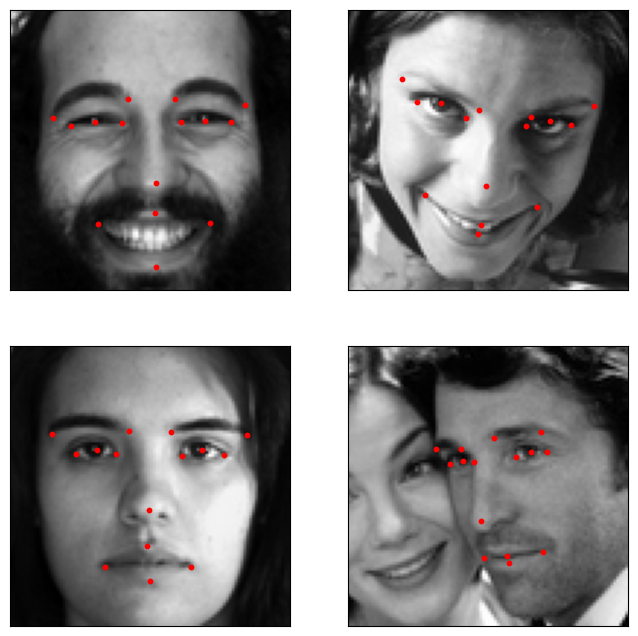

In [ ]:
# visualize four taining samples
%matplotlib inline
fig = plt.figure(figsize=(8,8))
for i in range(4):
     figure = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
     #print(X_train[i])
     plotData(X_train[i], y_train[i], figure)

# Define a model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot  as plt


#VGG-16 Style Architecture

model  =  Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))

print('\n\n CNN Architecture summary_________________________________________')
model.summary()



 CNN Architecture summary_________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 94, 94, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 47, 47, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 20, 64)        18496     
                                                   

In [ ]:
predictions = model.predict(X_test)

56/56 [==============================] - 5s 84ms/step


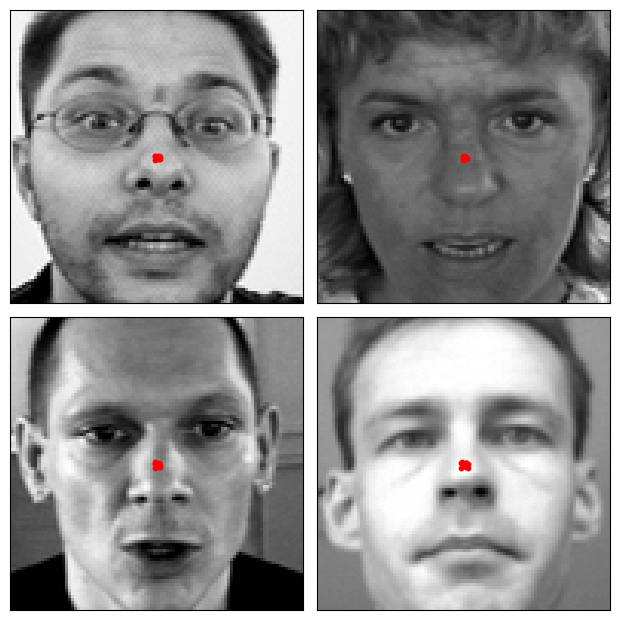

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plotData(X_test[i], predictions[i], ax)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam

hist = History()
epochs = 5
batch_size = 32
filepath='model_weights.ckpt'

checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

#Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, callbacks = [checkpointer,hist],
         batch_size=batch_size, epochs=epochs, verbose=1)


model.save('my_model.h5')

Epoch 1/5
54/54 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.6799
Epoch 1: val_loss improved from inf to 0.00455, saving model to model_weights.ckpt
54/54 [==============================] - 18s 309ms/step - loss: 0.0057 - accuracy: 0.6799 - val_loss: 0.0046 - val_accuracy: 0.6963
Epoch 2/5
54/54 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.6986
Epoch 2: val_loss did not improve from 0.00455
54/54 [==============================] - 15s 285ms/step - loss: 0.0049 - accuracy: 0.6986 - val_loss: 0.0047 - val_accuracy: 0.6963
Epoch 3/5
54/54 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.6980
Epoch 3: val_loss improved from 0.00455 to 0.00419, saving model to model_weights.ckpt
54/54 [==============================] - 17s 321ms/step - loss: 0.0047 - accuracy: 0.6980 - val_loss: 0.0042 - val_accuracy: 0.6963
Epoch 4/5
54/54 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.6963
Epoch 4: val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# get the checkpoint file to load the weights
model.load_weights(filepath)

print("Test data shape == {}".format(X_test.shape))

predictions = model.predict(X_test)

Test data shape == (1783, 96, 96, 1)
56/56 [==============================] - 4s 65ms/step


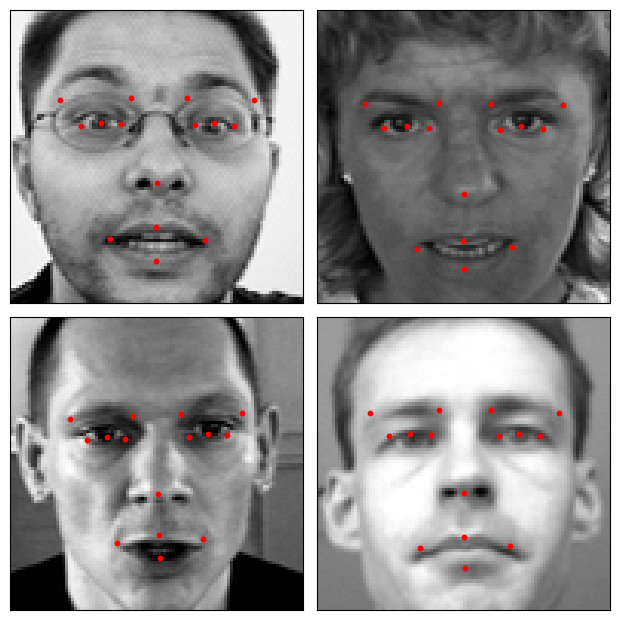

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plotData(X_test[i], predictions[i], ax)